In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
try:
    sys.path.remove("../py_src") # Hacky way to add higher directory to python modules path. 
except:
    pass
sys.path.append("../py_src") # Means that I dont have to make src/ a proper python package

## 1. Example Kalman filterings

We can generate some synthetic data, and run the Kalman filter to see how well we recover the state.

The Kalman filter depends on a series of physical parameters (e.g. GW angular frequency). 

Lets assume we know these perfectly, and see how the filter does.

In [3]:
from system_parameters import SystemParameters
from pulsars import Pulsars

from synthetic_data import SyntheticData
from plotting import plot_statespace,plot_all
from model import LinearModel
from kalman_filter import KalmanFilter
from bilby_wrapper import BilbySampler
from priors import priors_dict,bilby_priors_dict

In [4]:
import matplotlib.pyplot as plt 
import scienceplots

def plot_allV2(t,states,measurements,measurements_clean,predictions_x,predictions_y,psr_index,savefig=None):

    plt.style.use('science')

    tplot = t / (365*24*3600)
    state_i = states[:,psr_index]
    measurement_i = measurements[:,psr_index]
    measurement_clean_i = measurements_clean[:,psr_index]



    h,w = 12,8
    rows = 4
    cols = 1
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharex=False)

    ax1.plot(tplot,state_i,label='state')

    try:

        prediction_i = predictions_x[:,psr_index]
        ax1.plot(tplot,prediction_i,label = 'prediction')
    except:
        pass
    
    ax2.plot(tplot,measurement_i,label="measurement",c="C3")
    #ax2.plot(tplot,measurement_clean_i,label="measurement_clean",c="C5")


    try:
        prediction_i_y = predictions_y[:,psr_index]
        ax2.plot(tplot,prediction_i_y,label="prediction",c="C4")

        #Residuals
        residuals = prediction_i_y-measurement_i


        #print("Calculating residual")
        #print(prediction_i_y)
        #print(measurement_i)


        ax3.plot(tplot,residuals)

        print("Mean abs residual:", np.mean(np.abs(residuals)))
        ax4.hist(residuals,bins=50)

    except:
        pass 

    #ax1.legend()
    #ax2.legend()


    fs=18
    ax2.set_xlabel('t [years]', fontsize=fs)
    ax1.set_ylabel(r'$f_{\rm p}$ [Hz]', fontsize=fs)
    ax2.set_ylabel(r'$f_{\rm m}$ [Hz]', fontsize=fs)
    ax3.set_ylabel(r'Residual [Hz]', fontsize=fs)
    ax2.xaxis.set_tick_params(labelsize=fs-4)
    ax2.yaxis.set_tick_params(labelsize=fs-4)
    ax1.yaxis.set_tick_params(labelsize=fs-4)

    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    #plt.rcParams["font.family"] = "fantasy"


    if savefig != None:
        plt.savefig(f"../data/images/{savefig}.png", bbox_inches="tight",dpi=300)
   

    plt.show()
    





In [69]:
def plot_all_side_hist(t,states,measurements,measurements_clean,predictions_x,predictions_y,psr_index,savefig=None):

    plt.style.use('science')

    tplot = t / (365*24*3600)
    state_i = states[:,psr_index]
    measurement_i = measurements[:,psr_index]
    measurement_clean_i = measurements_clean[:,psr_index]



    h,w = 10,10

 
    fig = plt.figure(figsize=(h,w))

    rows = 3
    cols = 1
    ax1 = plt.subplot2grid((3, 1), (0, 0))
    ax2 = plt.subplot2grid((3, 1), (1, 0))
    ax3 = plt.subplot2grid((3, 1), (2, 0))


    nHz = 1e9
    ax1.plot(tplot,state_i*nHz,label='state',c='C0')

    try:

        prediction_i = predictions_x[:,psr_index]
        ax1.plot(tplot,prediction_i*nHz,label = 'prediction',c='C1')
    except:
        pass
    
    ax2.plot(tplot,measurement_i*nHz,label="measurement",c="C3")
    #ax2.plot(tplot,measurement_clean_i,label="measurement_clean",c="C5")


    try:
        prediction_i_y = predictions_y[:,psr_index]
        ax2.plot(tplot,prediction_i_y*nHz,label="prediction",c="C4")

        #Residuals
        residuals = (prediction_i_y-measurement_i) * nHz #nHz


        #print("Calculating residual")
        #print(prediction_i_y)
        #print(measurement_i)


        ax3.plot(tplot,residuals,c='C2')

        print("Mean abs residual:", np.mean(np.abs(residuals)))
        #ax4.hist(residuals,bins=50)

    except:
        pass 

    #ax1.legend()
    #ax2.legend()


    fs=18
    ax3.set_xlabel('t [years]', fontsize=fs)
    ax1.set_ylabel(r"$f'_{\rm p}$ [nHz]", fontsize=fs)
    ax2.set_ylabel(r'$f_{\rm m}$ [nHz]', fontsize=fs)
    ax3.set_ylabel(r'$\epsilon$ [nHz]', fontsize=fs)

    ax3.xaxis.set_tick_params(labelsize=fs-4)
    
    ax3.yaxis.set_tick_params(labelsize=fs-4)
    ax2.yaxis.set_tick_params(labelsize=fs-4)
    ax1.yaxis.set_tick_params(labelsize=fs-4)

    plt.subplots_adjust(wspace=0.12, hspace=0.0)


    ax2.yaxis.set_major_locator(plt.MaxNLocator(3))



    #ax4.yaxis.set_tick_params(labelsize=fs-4)
    #ax4.xaxis.set_tick_params(labelsize=fs-4)
    #ax4.set_xlabel(r'$\epsilon$ [nHz]', fontsize=fs)
    #ax4.set_ylabel(r'Count', fontsize=fs,labelpad=-2)




    #plt.rcParams["font.family"] = "fantasy"


    if savefig != None:
        plt.savefig(f"../data/images/{savefig}.png", bbox_inches="tight",dpi=300)
   

    plt.show()
    

In [70]:
h=1e-10
σp=1e-13
σm=1e-11
Npsr=20
cadence=0.5





#h=1e-10,σp=1e-13,σm=1e-11,Npsr=20,cadence=0.5






### 1.1. Canonical example

In [71]:
import numpy as np 

P    = SystemParameters(h=h,σp=σp,σm=σm,Npsr=Npsr,cadence=cadence)       #define the system parameters as a class
PTA  = Pulsars(P)               # setup the PTA
data = SyntheticData(PTA,P) # generate some synthetic data

#Define the model 
model = LinearModel(P)

#Initialise the Kalman filter
KF = KalmanFilter(model,data.f_measured,PTA)

# Run the KFwith the correct parameters
true_parameters = priors_dict(PTA,P)
model_likelihood, model_state_predictions_x,model_state_predictions_y = KF.likelihood(true_parameters)
print("Model likelihood is: ", model_likelihood)

INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1234


INFO:root:You are including the PSR terms in your synthetic data generation


Model likelihood is:  3357531.167635426


Mean abs residual: 0.0032022713148390073


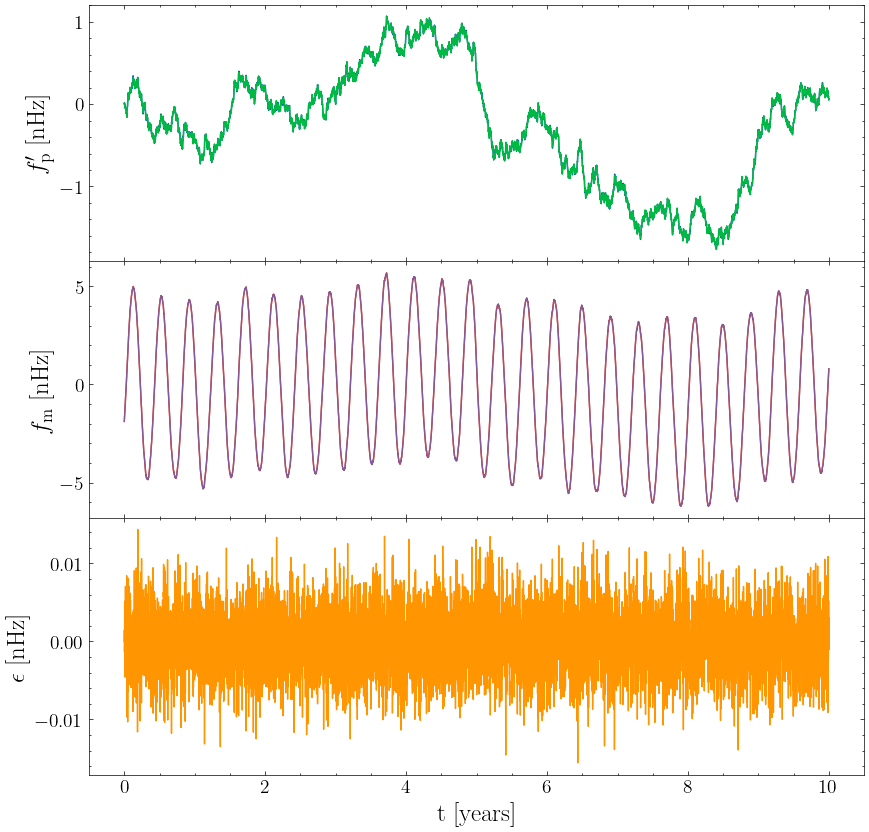

In [72]:
plot_all_side_hist(PTA.t, data.intrinsic_frequency, data.f_measured,data.f_measured_clean, model_state_predictions_x,model_state_predictions_y, psr_index=1,savefig='Kalman_example_true_params_single')


### 1.4 Canonical example with wrong parameters

In [73]:
import numpy as np 

P    = SystemParameters(h=h,σp=σp,σm=σm,Npsr=Npsr,cadence=cadence)        #define the system parameters as a class
PTA  = Pulsars(P)               # setup the PTA
data = SyntheticData(PTA,P) # generate some synthetic data

#Define the model 
model = LinearModel(P)

#Initialise the Kalman filter
KF = KalmanFilter(model,data.f_measured,PTA)

# Run the KFwith the correct parameters
true_parameters = priors_dict(PTA,P)
wrong_parameters = true_parameters.copy()

epsy= 5e-12
wrong_parameters["omega_gw"] = 5e-7 - epsy #Change one of the parameters which is fed to the KF


model_likelihood, model_state_predictions_x1,model_state_predictions_y1 = KF.likelihood(wrong_parameters)
print("Model likelihood is: ", model_likelihood)

INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1234
INFO:root:You are including the PSR terms in your synthetic data generation


Model likelihood is:  -3712040.8285273793


Mean abs residual: 0.007652760311651577


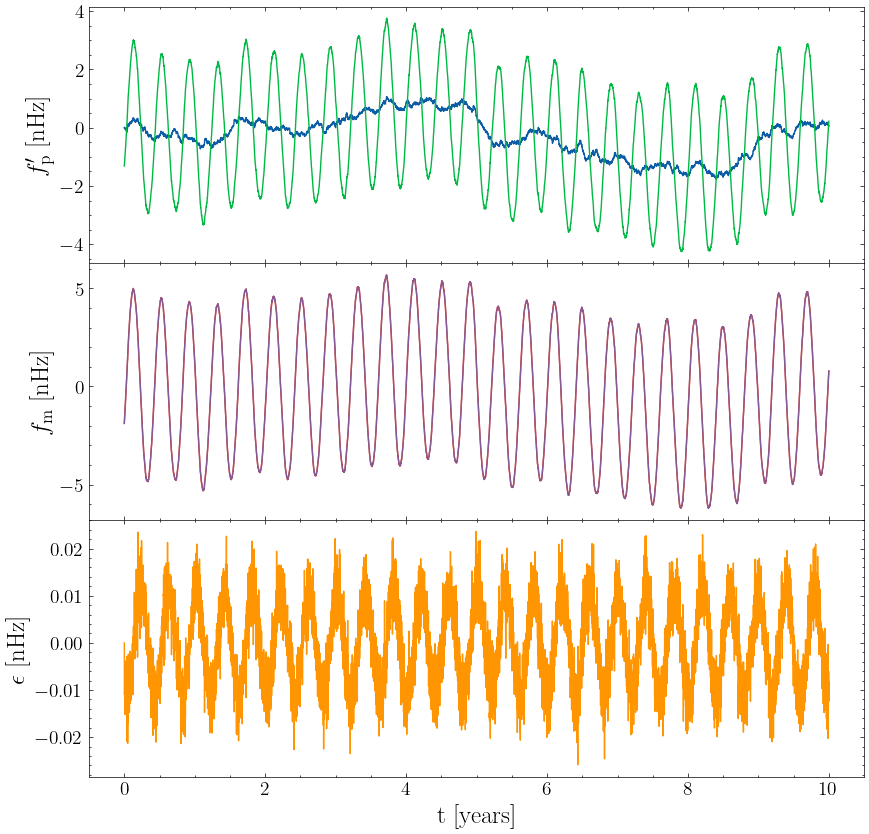

In [75]:
plot_all_side_hist(PTA.t, data.intrinsic_frequency, data.f_measured,data.f_measured_clean, model_state_predictions_x1,model_state_predictions_y1, psr_index=1,savefig='Kalman_example_wrong_params')


# Plot side by side

In [43]:

def plot_all_side_by_side(t,states,measurements,predictions_x1,predictions_y1,predictions_x2,predictions_y2,psr_index,savefig=None):

    plt.style.use('science')

    tplot = t / (365*24*3600)
    state_i = states[:,psr_index]
    measurement_i = measurements[:,psr_index]



    h,w = 15,8
    rows = 3
    cols = 2
 
    fig = plt.figure(figsize=(h,w))
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharey=False)
    nHz = 1e9
    
    #Plot the true state on both axes

    ax[0][0].plot(tplot,state_i*nHz,label='state',c='C0')
    ax[0][1].plot(tplot,state_i*nHz,label='state',c='C0')



    #Plot the predicted state
    prediction_i1 = predictions_x1[:,psr_index]
    prediction_i2 = predictions_x2[:,psr_index]
    ax[0][0].plot(tplot,prediction_i1*nHz,label = 'prediction',c='C1')
    ax[0][1].plot(tplot,prediction_i2*nHz,label = 'prediction',c='C1')








    #Plot the measured state
    
    ax[1][0].plot(tplot,measurement_i*nHz,label="measurement",c="C3")
    ax[1][1].plot(tplot,measurement_i*nHz,label="measurement",c="C3")


    #Plot the predicted measured state
    prediction_i_y1 = predictions_y1[:,psr_index]
    prediction_i_y2 = predictions_y2[:,psr_index]
   
    ax[1][0].plot(tplot,prediction_i_y1*nHz,label="prediction",c="C4")
    ax[1][1].plot(tplot,prediction_i_y2*nHz,label="prediction",c="C4")




    #Residuals
    residuals1 = (prediction_i_y1-measurement_i) * nHz #nHz
    residuals2 = (prediction_i_y2-measurement_i) * nHz #nHz


        


    ax[2][0].plot(tplot,residuals1,c='C2')
    ax[2][1].plot(tplot,residuals2,c='C2')




    fs=18
    ax[2][1].set_xlabel('t [years]', fontsize=fs)
    ax[2][0].set_xlabel('t [years]', fontsize=fs)



    ax[0][0].set_ylabel(r"$f'_{\rm p}$ [nHz]", fontsize=fs)
    ax[0][1].set_ylabel(r"$f'_{\rm p}$ [nHz]", fontsize=fs)

    ax[1][0].set_ylabel(r'$f_{\rm m}$ [nHz]', fontsize=fs)
    ax[1][1].set_ylabel(r'$f_{\rm m}$ [nHz]', fontsize=fs)

    
    ax[2][0].set_ylabel(r'$\epsilon$ [nHz]', fontsize=fs)
    ax[2][1].set_ylabel(r'$\epsilon$ [nHz]', fontsize=fs)


    for ax_i in fig.get_axes():
        ax_i.xaxis.set_tick_params(labelsize=fs-4)
        ax_i.yaxis.set_tick_params(labelsize=fs-4)
        ax_i.yaxis.set_major_locator(plt.MaxNLocator(3))


    if savefig != None:
        plt.savefig(f"../data/images/{savefig}.png", bbox_inches="tight",dpi=300)
   

    plt.show()
    

<Figure size 1500x800 with 0 Axes>

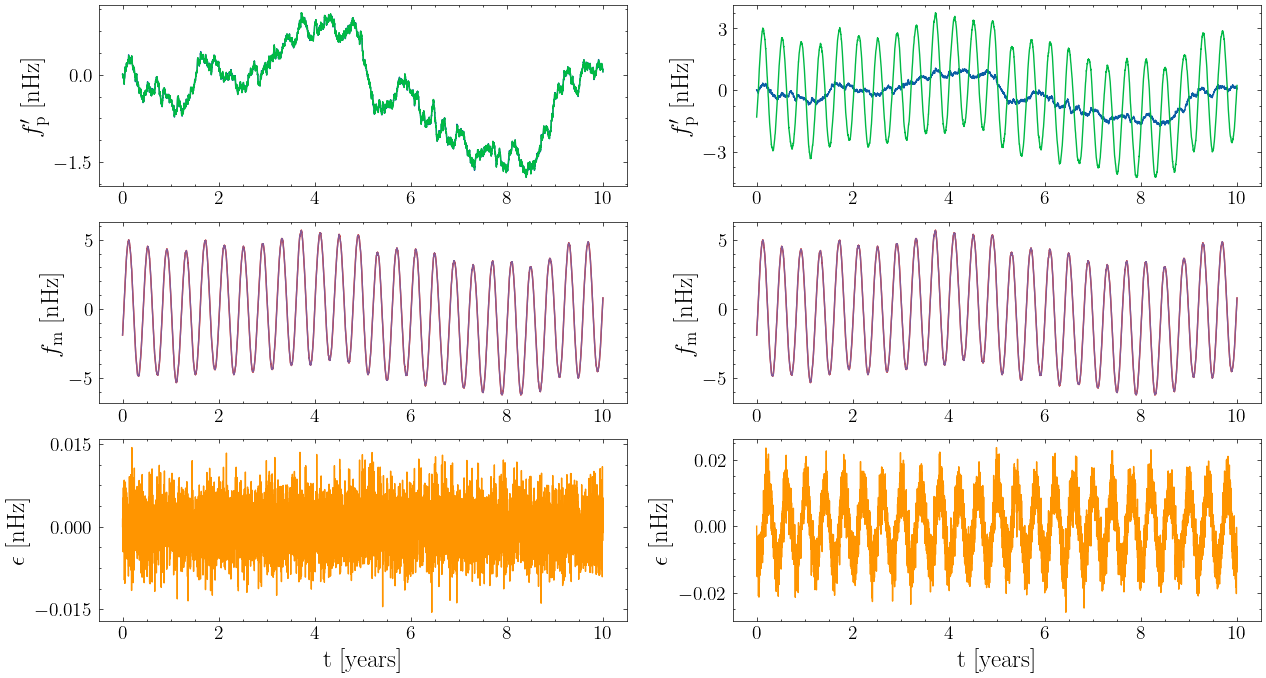

In [44]:
plot_all_side_by_side(PTA.t, 
                      data.intrinsic_frequency, 
                      data.f_measured,
                      model_state_predictions_x,model_state_predictions_y,
                      model_state_predictions_x1,model_state_predictions_y1,
                      psr_index=1,savefig='Kalman_example_both')





### Appendix

Here are some other ways of showingg it 


### Less severe change in omega:

INFO:root:Welcome to the Kalman Filter Nested Sampler for PTA GW systems
INFO:root:Random seed is 1234


INFO:root:You are including the PSR terms in your synthetic data generation


Model likelihood is:  -5538673.683994832
Mean abs residual: 0.012164365037822892


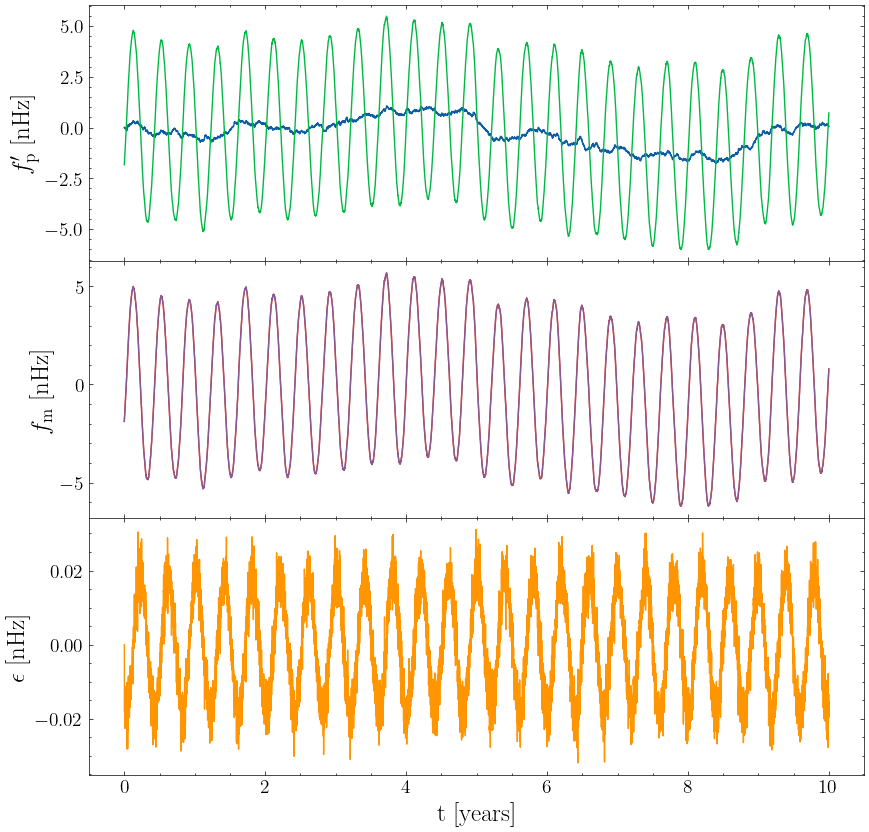

In [102]:
import numpy as np 


# h=1e-11
# σp=1e-14
# σm=1e-11
# Npsr=20
# cadence=0.5





P    = SystemParameters(h=1e-10,σp=1e-13,σm=1e-11,Npsr=20,cadence=0.5)       #define the system parameters as a class
PTA  = Pulsars(P)               # setup the PTA
data = SyntheticData(PTA,P) # generate some synthetic data

#Define the model 
model = LinearModel(P)

#Initialise the Kalman filter
KF = KalmanFilter(model,data.f_measured,PTA)

# Run the KFwith the correct parameters
true_parameters = priors_dict(PTA,P)

wrong_parameters = true_parameters.copy()
epsy= 5e-12
wrong_parameters["omega_gw"] = 5e-7 - epsy #Change one of the parameters which is fed to the KF
wrong_parameters["h"] = 1e-11
#wrong_parameters["phi0_gw"] = 0.80 - epsy #Change one of the parameters which is fed to the KF


model_likelihood, model_state_predictions_x,model_state_predictions_y = KF.likelihood(wrong_parameters)
print("Model likelihood is: ", model_likelihood)
plot_all_side_hist(PTA.t, data.intrinsic_frequency, data.f_measured,data.f_measured_clean, model_state_predictions_x,model_state_predictions_y, psr_index=1,savefig=None)


In [ ]:
import numpy as np 

P    = SystemParameters(h=1e-10,σp=1e-15,σm=1e-12,Npsr=20,cadence=0.5)       #define the system parameters as a class
PTA  = Pulsars(P)               # setup the PTA
data = SyntheticData(PTA,P) # generate some synthetic data

#Define the model 
model = LinearModel(P)

#Initialise the Kalman filter
KF = KalmanFilter(model,data.f_measured,PTA)

# Run the KFwith the correct parameters
true_parameters = priors_dict(PTA,P)
model_likelihood, model_state_predictions_x,model_state_predictions_y = KF.likelihood(true_parameters)
print("Model likelihood is: ", model_likelihood)
plot_allV2(PTA.t, data.intrinsic_frequency, data.f_measured,data.f_measured_clean, model_state_predictions_x,model_state_predictions_y, psr_index=1,savefig=None)
